In [1]:
import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import scipy as sc
from statsmodels.stats.multitest import fdrcorrection
import warnings
warnings.filterwarnings("ignore")

plt.style.use('./plot_script/mplstyle_czi')
import sys
sys.path.insert(0, './plot_script/')
import cziplot
dpi=150

In [2]:
# meta data
cluster_meta=pd.read_csv('../data/TableS7-cell_metadata.csv.gz',index_col=0).dropna()
cluster_meta['age']=cluster_meta['donor'].str[0]
cluster_meta['sex']=cluster_meta['donor'].str[1]
print(cluster_meta.shape)
gene_meta=pd.read_csv('../data/gencode.v37.annotation.intragenic.bed.gz',
                      names=['chr','start','end','gene_id','strand','tmp','gene_name','fn'],
                      index_col='gene_id', sep='\t')
gene_meta['len']=gene_meta['end']-gene_meta['start']
gene_meta=gene_meta[~gene_meta['chr'].isin(['chrY','chrM'])]
genedict_nametoid=dict(zip(gene_meta.gene_name, gene_meta.index))
genedict_idtoname=dict(zip(gene_meta.index, gene_meta.gene_name))
level2_order=cziplot.level2_order
level2_palette=cziplot.level2_palette

(54779, 22)


In [3]:
# DEs
fcthres=np.log2(1.2)
pthres=0.05

fulldata=pd.read_csv('../data/ageDEall.tsv.gz',sep='\t',index_col=0)
fulldata=fulldata[fulldata['celltype'].isin(cziplot.level2_order)]
fulldata=fulldata.join(gene_meta[['chr']])

data=fulldata[(fulldata['adj.P.Val']<pthres) & (np.abs(fulldata['logFC'])>fcthres)]

fulldata_df=fulldata[~fulldata['chr'].isin(['chrX','chrY','chrM'])].pivot(columns='celltype',values='logFC').fillna(100)
data_df=data[~(data['chr'].isin(['chrX','chrY','chrM']))].pivot(columns='celltype',values='logFC').fillna(100)

# Negative correlation between the change of mRNA expression and DNA methylation in aging.

In [4]:
# ! gdown -O /scratch/ranksum_median_intragenic_mCH_ageDMG.tsv.gz  https://drive.google.com/file/d/1FAcsV636ZdQPEjP_yS1V27n57D5GrYWy/view?usp=drive_link --fuzzy
# ! gdown -O /scratch/ranksum_median_intragenic_mCG_ageDMG.tsv.gz  https://drive.google.com/file/d/1h3nNKwHEJHdpZ1S8AaE78YRuHLRRyIL_/view?usp=drive_link --fuzzy
# ! gdown -O /scratch/ranksum_median_intragenic_TSS+-1k_mCH_ageDMG.tsv.gz  https://drive.google.com/file/d/1sxdtfJrUOuf9RZ-vK4mItp_q3r_dlcvv/view?usp=drive_link --fuzzy
# ! gdown -O /scratch/ranksum_median_intragenic_TSS+-1k_mCG_ageDMG.tsv.gz  https://drive.google.com/file/d/16xt_4PPHUBcecuH5ZR0kRpvlvEcLRBD3/view?usp=drive_link --fuzzy

## scatter plot

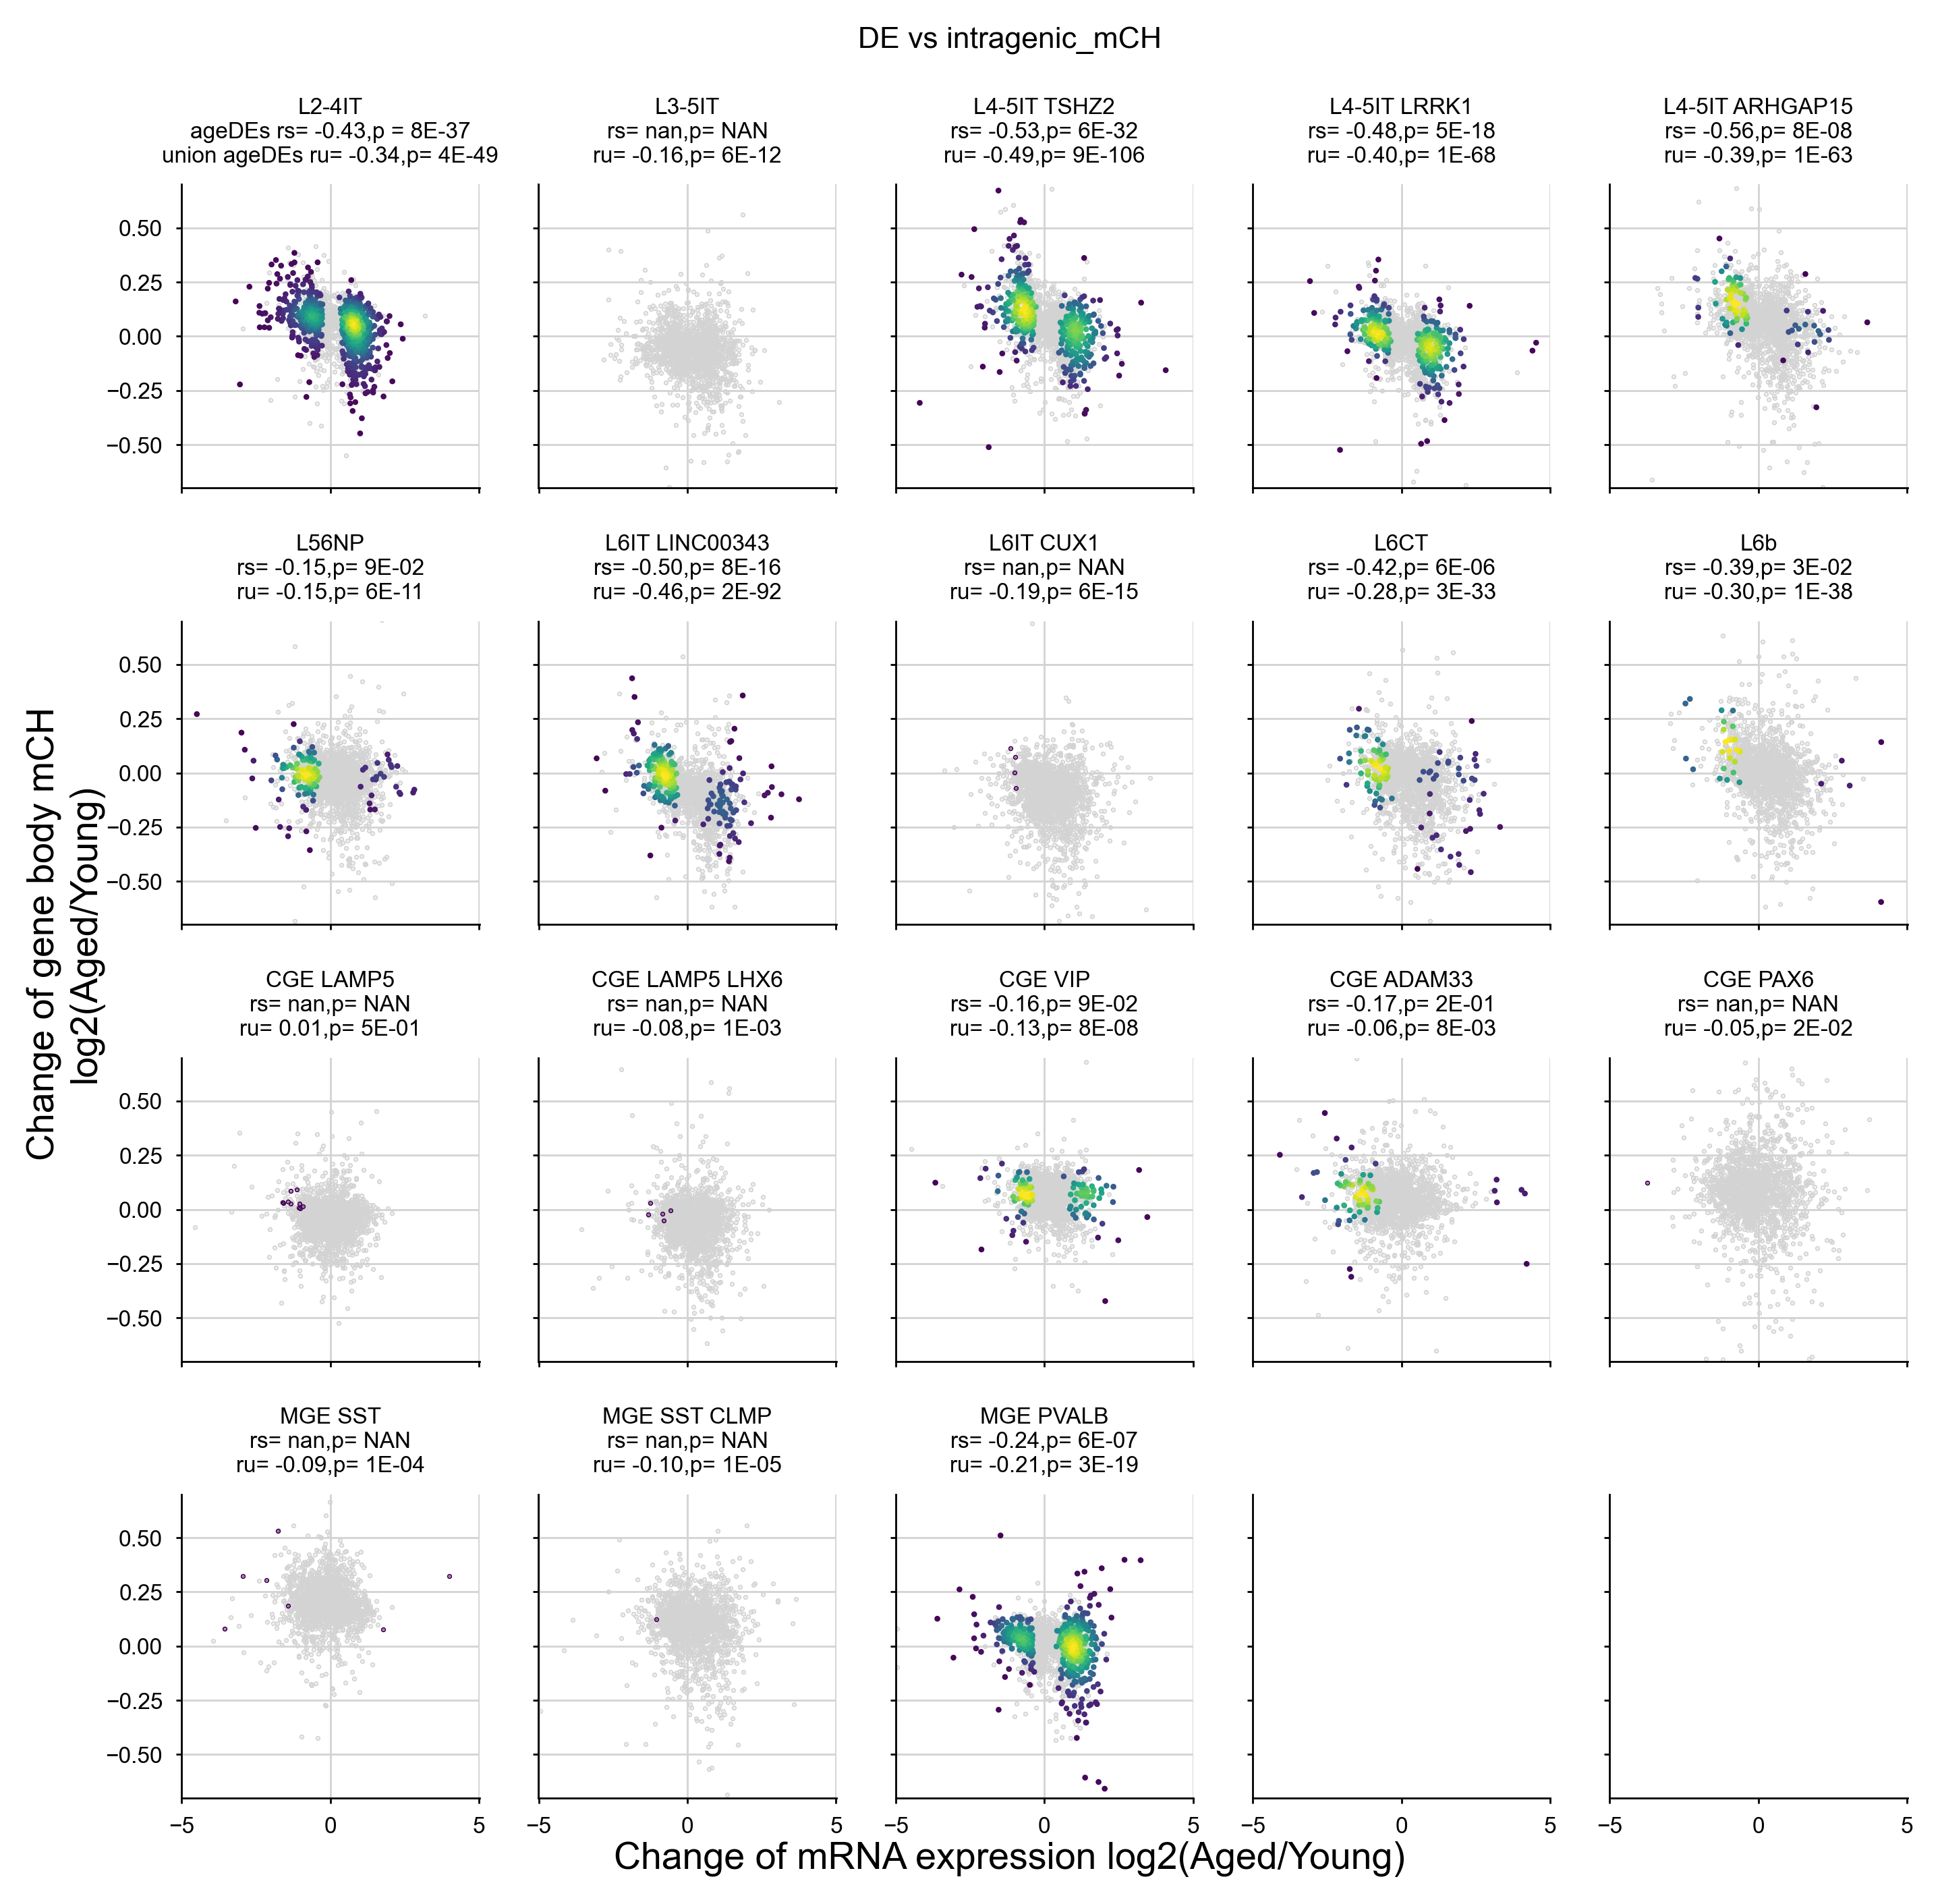

In [5]:
region='intragenic_mCH'
mC_data=pd.read_csv(f'/scratch/ranksum_median_{region}_ageDMG.tsv.gz',sep='\t',index_col=0,header=[0,1])
mC_data=mC_data.xs('log2FC',axis=1,level=1)

fig,axs=plt.subplots(4,5,figsize=(7,7),sharex=True,sharey=True,dpi=400)
for i,celltype in enumerate(level2_order):
    ax=axs[i//5,i%5]
    combine_alldegene=fulldata_df.loc[data_df.index.unique()][[celltype]].join(mC_data[[celltype]],lsuffix='_rna').sort_values(celltype).replace([-np.inf,np.inf,100],np.nan).dropna()
    combine_alldegene.index = combine_alldegene.index.map(genedict_idtoname)
    
    ax.scatter(combine_alldegene[f'{celltype}_rna'],combine_alldegene[f'{celltype}'],s=0.1,color='lightgrey',rasterized=True)
    r_all,p_all=sc.stats.spearmanr(combine_alldegene[f'{celltype}_rna'],combine_alldegene[f'{celltype}'])
    
    if celltype in data['celltype'].unique():
        combine_degene=data_df[[celltype]].join(mC_data[[celltype]],lsuffix='_rna',how='inner').sort_values(celltype).replace([-np.inf,np.inf,100],np.nan).dropna()
        combine_degene.index = combine_degene.index.map(genedict_idtoname)
        # print(len(combine_degene))
        if len(combine_degene)>25:
            # print(celltype)
            x=combine_degene[f'{celltype}_rna']
            y=combine_degene[celltype]
            xy = np.vstack([x,y])
            z = sc.stats.gaussian_kde(xy)(xy)
            ax.scatter(x,y,c=z,s=0.3,cmap='viridis',rasterized=True)
            r_de,p_de=sc.stats.spearmanr(combine_degene[f'{celltype}_rna'],combine_degene[f'{celltype}'])
        else:
            ax.scatter(combine_degene[f'{celltype}_rna'],combine_degene[f'{celltype}'],s=0.1,c='#440154FF',rasterized=True)
    
    if i==0:
        ax.set_title(f'{cziplot.celltype_simdic[celltype]}\nageDEs rs= {r_de:.2f},p = {p_de:.0E}\nunion ageDEs ru= {r_all:.2f},p= {p_all:.0E}',fontsize=6)
    else:
        ax.set_title(f'{cziplot.celltype_simdic[celltype]}\nrs= {r_de:.2f},p= {p_de:.0E}\nru= {r_all:.2f},p= {p_all:.0E}',fontsize=6)
    ax.set_ylim([-0.7,0.7])
    ax.set_xlim([-5.01,5.01])
    ax.grid()
    r_de=np.nan
    p_de=np.nan
fig.text(0.5, 0.01, 'Change of mRNA expression log2(Aged/Young)', ha='center', va='center')
fig.text(0.0, 0.5, 'Change of gene body mCH\nlog2(Aged/Young)', ha='center', va='center', rotation='vertical')
plt.suptitle(f'DE vs {region}')
plt.tight_layout()

## summary barplot

### the union of age-DEGs

Text(-0.45, 0.1, '* FDR<0.01')

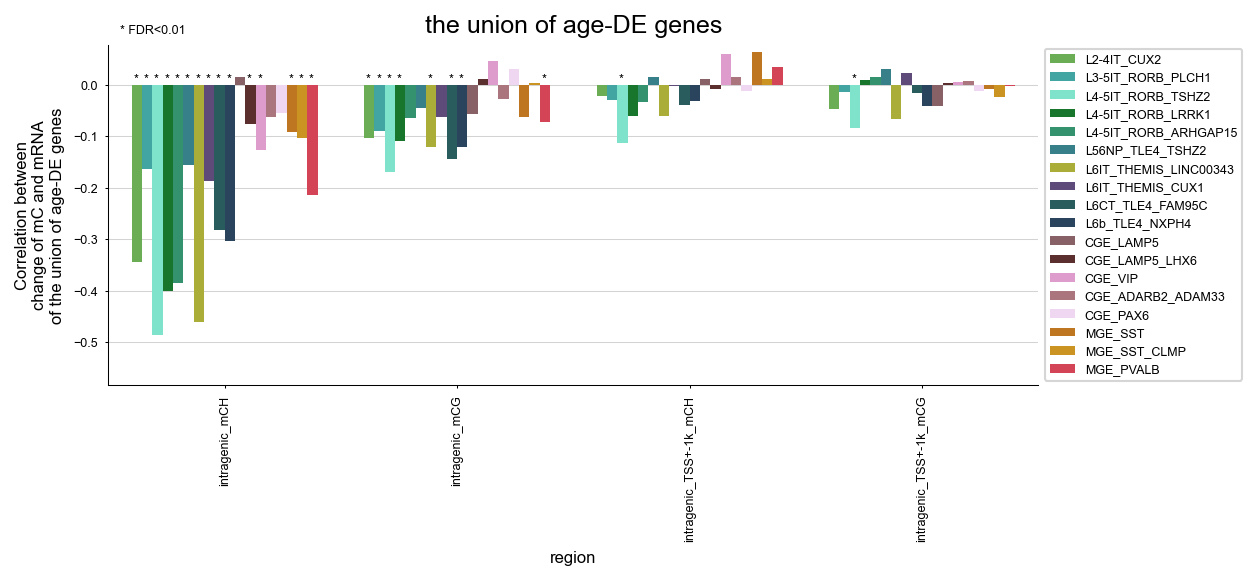

In [6]:
corr_df=pd.DataFrame(columns=['celltype','r','p','region'])

regions=['intragenic_mCH','intragenic_mCG','intragenic_TSS+-1k_mCH','intragenic_TSS+-1k_mCG']

for region in regions:
    mC_data=pd.read_csv(f'/scratch/ranksum_median_{region}_ageDMG.tsv.gz',sep='\t',index_col=0,header=[0,1])
    mC_data=mC_data.xs('log2FC',axis=1,level=1)

    for i,celltype in enumerate(level2_order):
        combine_alldegene=fulldata_df.loc[data_df.index.unique()][[celltype]].join(mC_data[[celltype]],lsuffix='_rna').sort_values(celltype).replace([-np.inf,np.inf,100],np.nan).dropna()
        # print(combine_alldegene.shape)
        r,p=sc.stats.spearmanr(combine_alldegene[f'{celltype}_rna'],combine_alldegene[celltype])
        corr_df.loc[len(corr_df)]=[celltype,r,p,region]

    
_,corr_df['fdr']=fdrcorrection(corr_df['p'])
corr_df.sort_values('fdr')
corr_df['sig']=False
corr_df.loc[corr_df['fdr']<0.01,'sig']=True
corr_df=corr_df[corr_df['celltype'].isin(level2_order)]
corr_df['celltype'] = pd.Categorical(corr_df['celltype'], level2_order)
corr_df['region'] = pd.Categorical(corr_df['region'], ['intragenic_mCH','intragenic_mCG','intragenic_TSS+-1k_mCH','intragenic_TSS+-1k_mCG'])
corr_df=corr_df.sort_values(['region','celltype']).reset_index(drop=True)
x_var='region'
y_var='r'
hue_var='celltype'

sig_sorted = corr_df.sort_values([hue_var,'region']).reset_index(drop=True)['sig'].values

plt.figure(figsize=(8,3),dpi=dpi)    
barplot = sns.barplot(x=x_var, y=y_var, hue=hue_var,data=corr_df,palette=level2_palette)
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=90)

for p,sig in zip(barplot.patches,sig_sorted):
    if sig == True:
        barplot.annotate('*', (p.get_x() + p.get_width()/2.5, 0.01),
                    ha='center', va='center', fontsize=6, color='black')

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
plt.ylim([corr_df[y_var].min()*1.2,corr_df[y_var].max()*1.2])
plt.ylabel('Correlation between\nchange of mC and mRNA\nof the union of age-DE genes')
plt.grid(axis='y')
barplot.set_axisbelow(True)
plt.title('the union of age-DE genes')
plt.text(-0.45,0.1,'* FDR<0.01',fontsize=6)

### age-DEGs

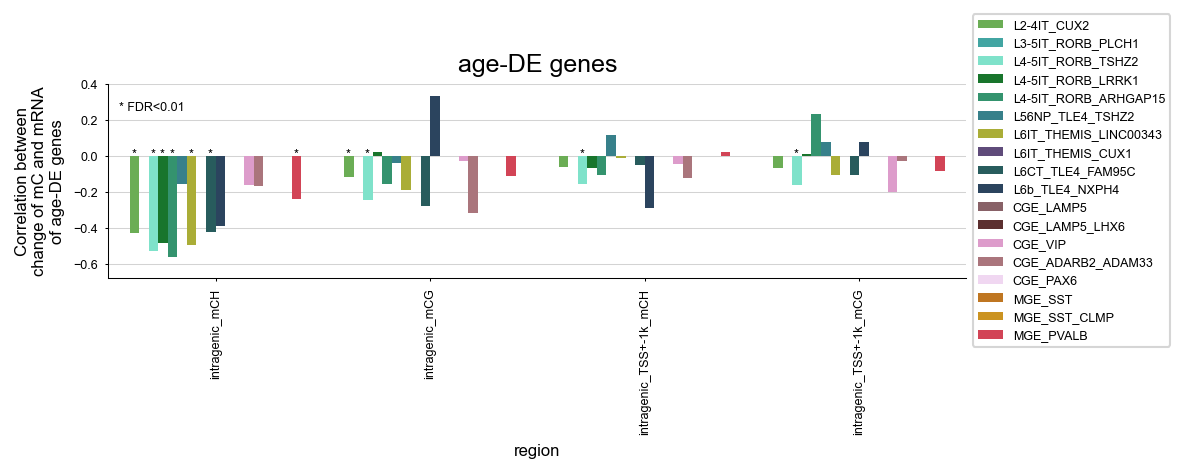

In [7]:
corr_df=pd.DataFrame(columns=['celltype','r','p','region'])
corr_df2=pd.DataFrame(columns=['celltype','r','p','region','fdr','sig'])

regions=['intragenic_mCH','intragenic_mCG','intragenic_TSS+-1k_mCH','intragenic_TSS+-1k_mCG']

## only num. of ageDEs >25 are taken 
level2_order_tmp=[]
for i in level2_order:
    if len(data[data['celltype']==i]) >25:
        level2_order_tmp.append(i)

for region in regions:
    mC_data=pd.read_csv(f'/scratch/ranksum_median_{region}_ageDMG.tsv.gz',sep='\t',index_col=0,header=[0,1])
    mC_data=mC_data.xs('log2FC',axis=1,level=1)

    for celltype in level2_order_tmp:
        combine_degene=data_df[[celltype]].join(mC_data[[celltype]],lsuffix='_rna').sort_values(celltype).replace([-np.inf,np.inf,100],np.nan).dropna()
        r,p=sc.stats.spearmanr(combine_degene[f'{celltype}_rna'],combine_degene[celltype])
        corr_df.loc[len(corr_df)]=[celltype,r,p,region]
        
    for celltype in set(level2_order)-set(level2_order_tmp):
        corr_df2.loc[len(corr_df2)]=[celltype,0,1,region,1,False]
 
_,corr_df['fdr']=fdrcorrection(corr_df['p'])
corr_df.sort_values('fdr')
corr_df['sig']=False
corr_df.loc[corr_df['fdr']<0.01,'sig']=True
corr_df=corr_df.append(corr_df2)
corr_df['celltype'] = pd.Categorical(corr_df['celltype'], level2_order)
corr_df['region'] = pd.Categorical(corr_df['region'], ['intragenic_mCH','intragenic_mCG','intragenic_TSS+-1k_mCH','intragenic_TSS+-1k_mCG'])
corr_df=corr_df.sort_values(['region','celltype']).reset_index(drop=True)
x_var='region'
y_var='r'
hue_var='celltype'


plt.figure(figsize=(8,3),dpi=dpi)  
barplot = sns.barplot(x=x_var, y=y_var, hue=hue_var,data=corr_df,palette=level2_palette)
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=90)

sig_sorted = corr_df.sort_values([hue_var,'region']).reset_index(drop=True)['sig'].values
for p,sig in zip(barplot.patches,sig_sorted):
    if sig == True:
        barplot.annotate('*', (p.get_x() + p.get_width()/2.5, 0.01),
                    ha='center', va='center', fontsize=6, color='black')

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
plt.ylim([corr_df[y_var].min()*1.2,corr_df[y_var].max()*1.2])
plt.ylabel('Correlation between\nchange of mC and mRNA\nof age-DE genes')
plt.grid(axis='y')
barplot.set_axisbelow(True)
plt.title('age-DE genes')
plt.text(-0.45,0.25,'* FDR<0.01',fontsize=6)
plt.tight_layout()

### all expressed genes

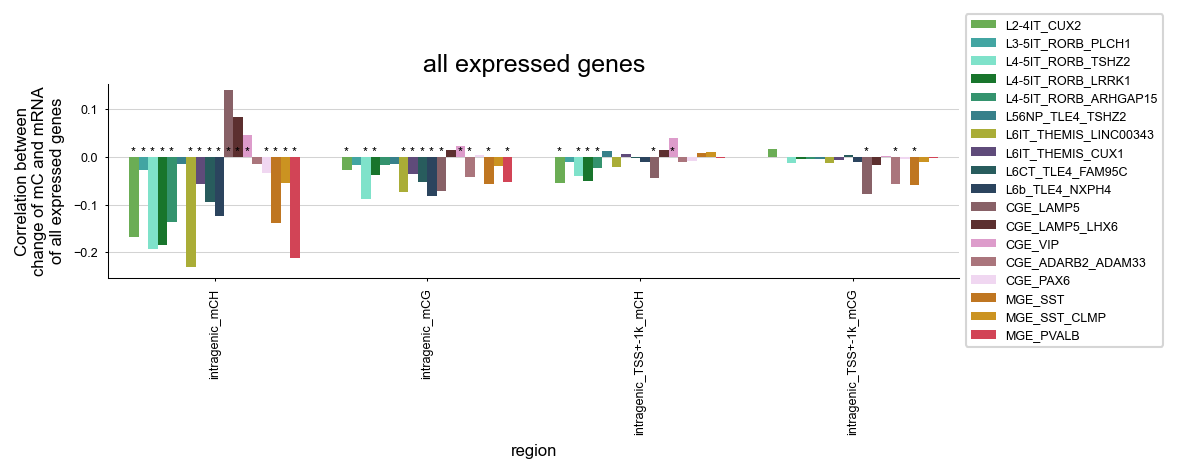

In [8]:
corr_df=pd.DataFrame(columns=['celltype','r','p','region'])

regions=['intragenic_mCH','intragenic_mCG','intragenic_TSS+-1k_mCH','intragenic_TSS+-1k_mCG']

for region in regions:
    mC_data=pd.read_csv(f'/scratch/ranksum_median_{region}_ageDMG.tsv.gz',sep='\t',index_col=0,header=[0,1])
    mC_data=mC_data.xs('log2FC',axis=1,level=1)

    for i,celltype in enumerate(level2_order):
        combine_allgene=fulldata_df[[celltype]].join(mC_data[[celltype]],lsuffix='_rna').sort_values(celltype).replace([-np.inf,np.inf,100],np.nan).dropna()
        # print(combine_allgene.shape)
        r,p=sc.stats.spearmanr(combine_allgene[f'{celltype}_rna'],combine_allgene[celltype])
        corr_df.loc[len(corr_df)]=[celltype,r,p,region]
    
_,corr_df['fdr']=fdrcorrection(corr_df['p'])
corr_df.sort_values('fdr')
corr_df['sig']=False
corr_df.loc[corr_df['fdr']<0.01,'sig']=True
corr_df=corr_df[corr_df['celltype'].isin(level2_order)]
corr_df['celltype'] = pd.Categorical(corr_df['celltype'], level2_order)
corr_df['region'] = pd.Categorical(corr_df['region'], ['intragenic_mCH','intragenic_mCG','intragenic_TSS+-1k_mCH','intragenic_TSS+-1k_mCG'])
corr_df=corr_df.sort_values(['region','celltype']).reset_index(drop=True)
x_var='region'
y_var='r'
hue_var='celltype'

sig_sorted = corr_df.sort_values([hue_var,'region']).reset_index(drop=True)['sig'].values

plt.figure(figsize=(8,3),dpi=dpi)     
barplot = sns.barplot(x=x_var, y=y_var, hue=hue_var,data=corr_df,palette=level2_palette)
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=90)

for p,sig in zip(barplot.patches,sig_sorted):
    if sig == True:
        barplot.annotate('*', (p.get_x() + p.get_width()/2.5, 0.01),
                    ha='center', va='center', fontsize=6, color='black')

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
plt.ylim([corr_df[y_var].min()*1.1,corr_df[y_var].max()*1.1])
plt.ylabel('Correlation between\nchange of mC and mRNA\nof all expressed genes')
plt.grid(axis='y')
barplot.set_axisbelow(True)
plt.title('all expressed genes')
plt.tight_layout()